In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from grouper import group_by_volume, group_by_time
from pyfolio.timeseries import perf_stats
from functools import partial
from utils import chart_price, plot, backtest
import sys
sys.path.append('/home/tomek/ib_tools')
from indicators import get_ATR, get_signals
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
time_int = 60
periods = 20
multiplier = 50
threshold = 1
bankroll = 15000

In [3]:
contract = pd.read_pickle('data/minute_ES_cont_non_active_included.pickle')
#contract = contract.loc['20180202':]
contract = contract.loc['20190401':]

In [4]:
avg_vol = contract.loc['20190621':].volume.rolling(time_int).sum().mean()
avg_vol

63604.29326641914

In [5]:
vol_candles = group_by_volume(contract, avg_vol)
#vol_candles['atr'] = get_ATR(vol_candles, atr_periods)
vol_candles

,date,open,high,low,close,barCount,volume
label,,,,,,,
0,2019-04-01 04:22:00,2844.50,2858.25,2844.50,2857.50,17892,63568
1,2019-04-01 10:34:00,2857.50,2860.50,2854.50,2860.00,16602,63400
2,2019-04-01 14:29:00,2860.25,2861.25,2854.50,2858.50,12364,59214
3,2019-04-01 15:32:00,2858.25,2860.75,2853.75,2860.25,11325,64888
4,2019-04-01 15:42:00,2860.25,2860.75,2856.00,2857.50,10074,66951
...,...,...,...,...,...,...,...
2415,2019-09-04 21:59:00,2938.25,2938.75,2936.75,2938.25,5087,59743
2416,2019-09-05 02:38:00,2938.25,2945.25,2936.50,2943.50,13944,81663
2417,2019-09-05 03:52:00,2943.75,2964.50,2941.50,2964.25,16532,62567


In [16]:
data = pd.DataFrame({'date': vol_candles.date,
                     'open': vol_candles.open,
                    'close': vol_candles.close})
data['max'] = data.close.rolling(periods).max()
data['min'] = data.close.rolling(periods).min()
data['mid'] = data[['min', 'max']].mean(axis=1)
data.set_index('date', inplace=True)
data = data.iloc[periods*3:]

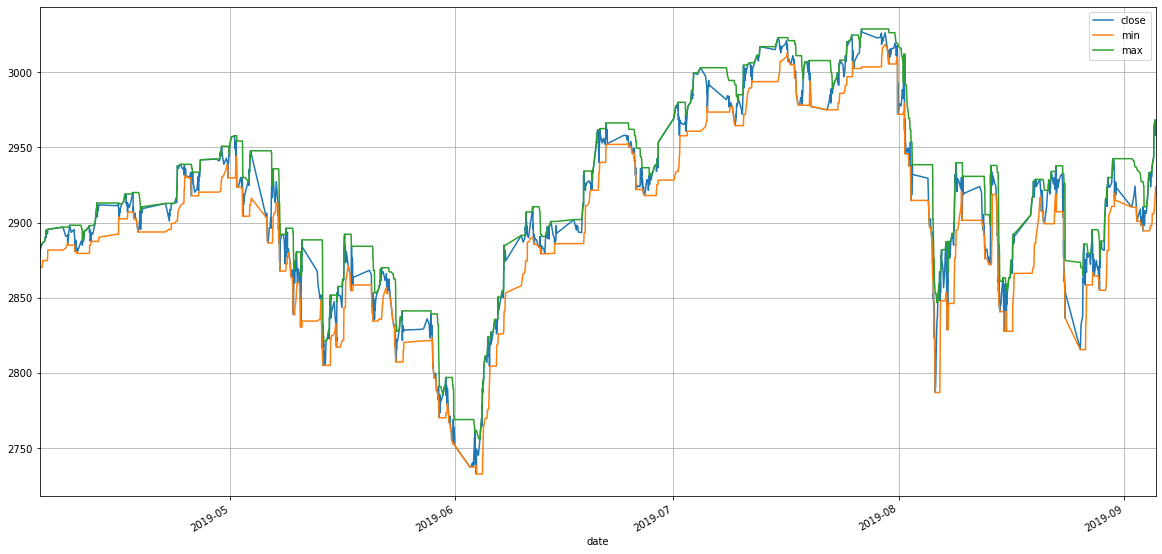

In [17]:
data[['close', 'min', 'max']].plot(figsize=(20,10), grid=True);

In [24]:
data['breakout'] = data['close'] - data['mid']
data['breakout_norm'] = data['breakout']/data['breakout'].rolling(periods).std()
data['breakout_norm_mean'] = data['breakout_norm'].ewm(span=periods).mean()
data.reset_index(inplace=True)

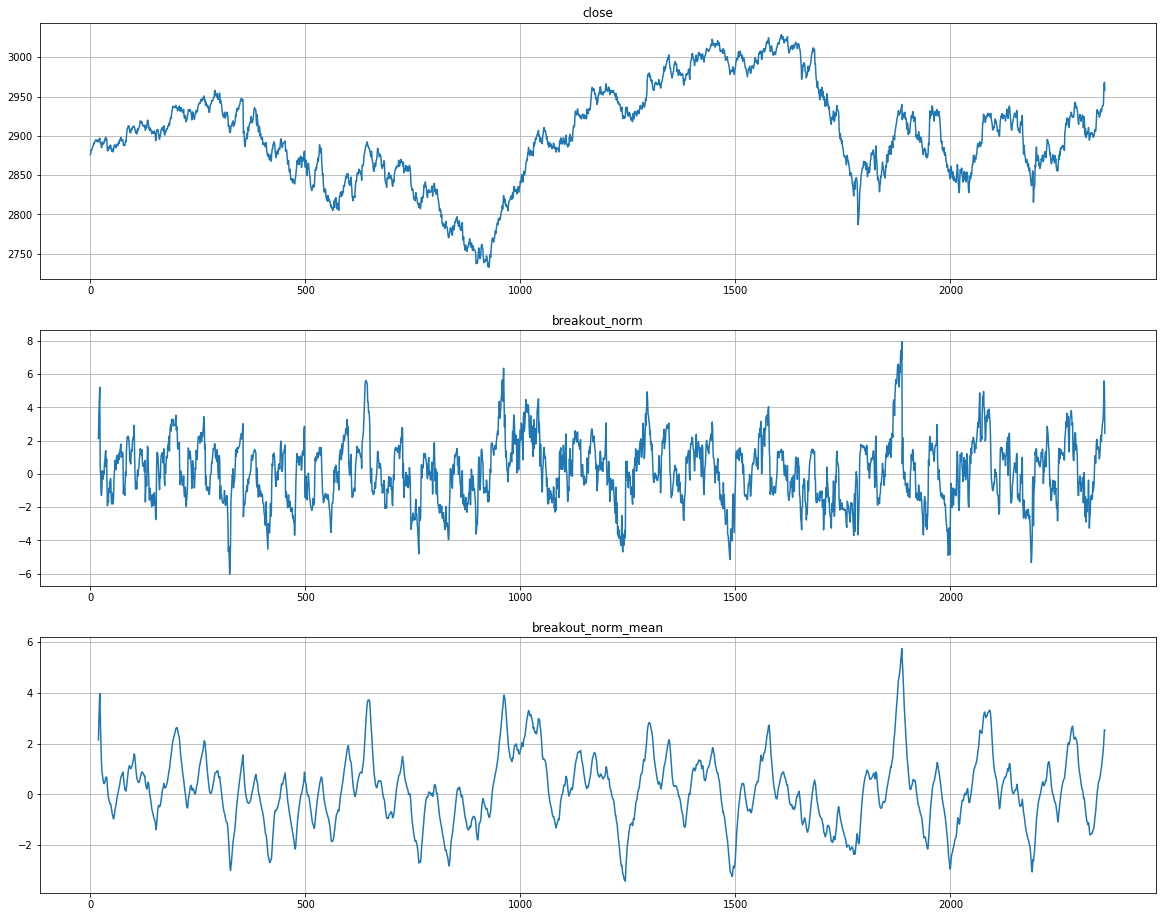

In [25]:
plot(data[['close', 'breakout_norm', 'breakout_norm_mean']])

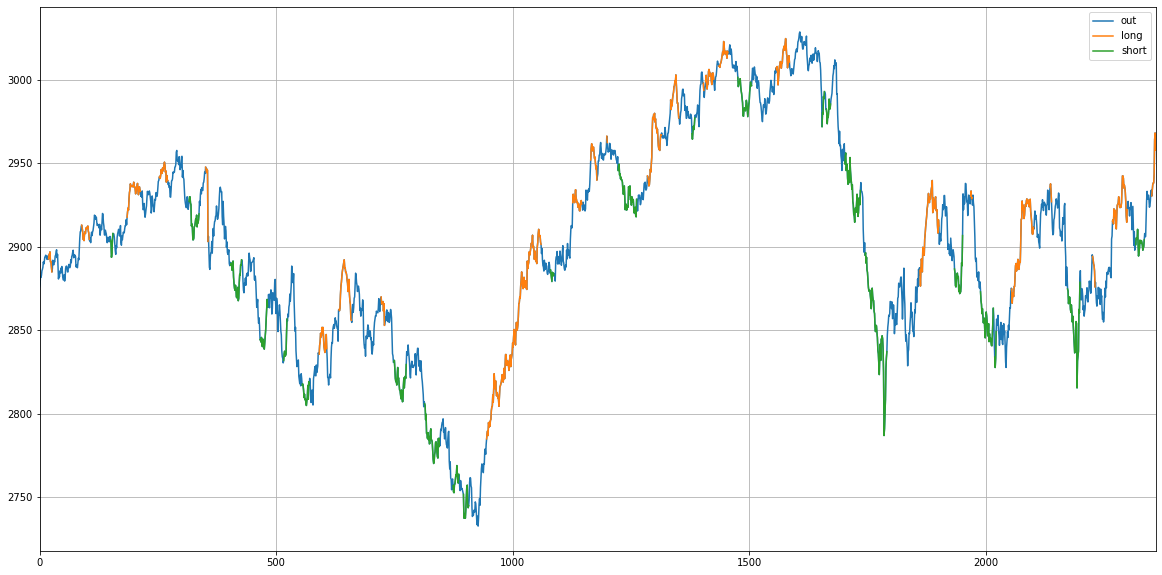

In [26]:
chart_price(data.close, data.breakout_norm_mean, 1, -1)

Annual return          0.026683
Cumulative returns     0.011667
Annual volatility      0.899705
Sharpe ratio           0.468923
Calmar ratio           0.059241
Stability              0.135138
Max drawdown          -0.450413
Omega ratio            1.094373
Sortino ratio          0.732973
Skew                   0.485769
Kurtosis               1.514902
Tail ratio             1.155455
Daily value at risk   -0.111678

Win percent               0.300000
Average gain           1253.333333
Average loss           -532.142857
Avg gain/loss ratio       2.355257
Position EV               3.500000
Positions per day         0.450450
Days per position         2.220000
Days                    111.000000
Positions                50.000000
Trades                   99.000000


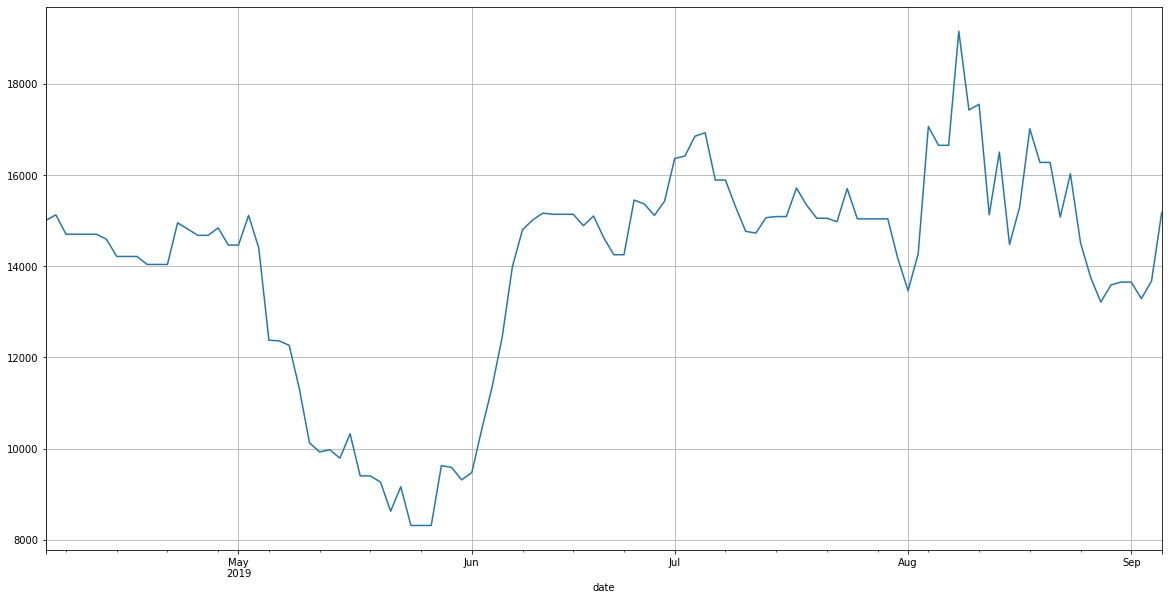

In [27]:
data.set_index('date', inplace=True)
backtest(data.open.copy(),
         data.breakout_norm_mean.copy(), 
         threshold, multiplier, bankroll)